In [137]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Fetch Movie Data from API


In [138]:
load_dotenv(".env")
api_key = os.getenv("API_KEY")
if not api_key:
    raise ValueError("API_KEY not found.") 
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818,
    24428, 168259, 99861, 284054, 12445, 181808, 330457,
    351286, 109445, 321612, 260513
]
selected_movie_ids = []
for movie_id in movie_ids:
    if movie_id == 0:
        continue
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?append_to_response=credits&api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        selected_movie_ids.append(response.json())
    else:
        print(f"Failed to fetch movie {movie_id}: {response.status_code}")

### Store data as a Pandas DataFrame

In [139]:
df_movie = pd.DataFrame(selected_movie_ids) #Converted DataFrame

In [140]:
df_movie['id'] # check if data is loaded correctly

0     299534
1      19995
2     140607
3     299536
4        597
5     135397
6     420818
7      24428
8     168259
9      99861
10    284054
11     12445
12    181808
13    330457
14    351286
15    109445
16    321612
17    260513
Name: id, dtype: int64

In [141]:
df_movie.columns # check column names

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'origin_country', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

### End of Step 1: Fetch Movie Data from API

# Step 2: Data Cleaning and Preprocessing

In [142]:
# 1: the irrelevant columns to drop
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
for col in cols_to_drop:
    # Check if the column actually exists in the DataFrame to avoid errors
    if col in cols_to_drop:
        df_movie.drop(col, axis=1, inplace=True)    # axis=1 refers to columns. inplace=True modifies the DataFrame directly.


In [143]:
df_movie.columns # check column names again after dropping columns

Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

In [144]:

# 1. Load data into DataFrame
df_movie = pd.DataFrame(selected_movie_ids)

# 2. Evaluate JSON-like columns
extracted_columns = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_countries', 'production_companies', 'credits']

# 3. Extract and clean points
for column in extracted_columns:
    if column == 'belongs_to_collection':
        # Extracts 'name' from belongs_to_collection dict, else None
        df_movie[column] = df_movie[column].apply(lambda x: x['name'] if isinstance(x, dict) else None)
    else:
        # Extracts other columns as pipe-separated strings
        df_movie[column] = df_movie[column].apply(lambda x: "|".join([item['name'] for item in x]) if isinstance(x, list) else None)

# 4. Display value counts for each extracted column
for col in extracted_columns:        
    print(f"Value counts for {col}:")
    print(df_movie[col].value_counts().head()) 
    print("\n")

Value counts for belongs_to_collection:
belongs_to_collection
The Avengers Collection     4
Star Wars Collection        2
Frozen Collection           2
Jurassic Park Collection    2
Avatar Collection           1
Name: count, dtype: int64


Value counts for genres:
genres
Adventure|Action|Science Fiction             3
Action|Adventure|Science Fiction|Thriller    2
Action|Adventure|Science Fiction             2
Action|Adventure|Fantasy|Science Fiction     1
Drama|Romance                                1
Name: count, dtype: int64


Value counts for spoken_languages:
spoken_languages
English                                              9
English|日本語|                                         1
English|Español                                      1
English|                                             1
English|Français|Deutsch|svenska|Italiano|Pусский    1
Name: count, dtype: int64


Value counts for production_countries:
production_countries
United States of America                   16
Unit

### Handling Missing & Incorrect Data

In [145]:
# Convert column datatypes
numeric_cols = [
    'budget', 
    'id', 
    'popularity', 
    'revenue', 
    'runtime', 
    'vote_average', 
    'vote_count'
]

print("--- Converting Data Types ---")

# --- 2. Convert Numeric Columns ---
for col in numeric_cols:
    # errors='coerce' turns invalid parsing into NaN
    df_movie[col] = pd.to_numeric(df_movie[col], errors='coerce')

# --- 3. Convert Release Date ---
df_movie['release_date'] = pd.to_datetime(df_movie['release_date'], errors='coerce')

# --- 4. Verify the Changes ---
print("\nNew Data Types:")
print(df_movie.dtypes)

print("\nSample Data Check (First 5 rows):")
print(df_movie[['title', 'release_date', 'budget', 'revenue']].head())

--- Converting Data Types ---

New Data Types:
adult                              bool
backdrop_path                    object
belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
id                                int64
imdb_id                          object
origin_country                   object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                           int64
runtime                           int64
spoken_languages                 object
status                           object
tagline                          object
title                            object
video                            

In [146]:
df_movie.isnull().sum() # Check for missing values in each column

adult                     0
backdrop_path             0
belongs_to_collection     2
budget                    0
genres                    0
homepage                  0
id                        0
imdb_id                   0
origin_country            0
original_language         0
original_title            0
overview                  0
popularity                0
poster_path               0
production_companies      0
production_countries      0
release_date              0
revenue                   0
runtime                   0
spoken_languages          0
status                    0
tagline                   0
title                     0
video                     0
vote_average              0
vote_count                0
credits                  18
dtype: int64

In [147]:
# (Assuming df_movie is active from previous steps)

print("--- Pre-Cleaning Statistics (Budget/Revenue/Runtime) ---")
print(df_movie[['budget', 'revenue', 'runtime']].describe())

# ---------------------------------------------------------
# 1. Replace Unrealistic Values (0 -> NaN)
# ---------------------------------------------------------
# Zeros in these columns imply missing data, not that the movie cost $0 or lasted 0 minutes.
target_cols = ['budget', 'revenue', 'runtime']
df_movie[target_cols] = df_movie[target_cols].replace(0, np.nan)

# ---------------------------------------------------------
# 2. Unit Conversion (Dollars -> Millions)
# ---------------------------------------------------------
# We divide by 1,000,000. NaN values remain NaN automatically.
df_movie['budget'] = df_movie['budget'] / 1000000
df_movie['revenue'] = df_movie['revenue'] / 1000000

# ---------------------------------------------------------
# 3. Handle Zero Votes
# ---------------------------------------------------------
# If vote_count is 0, a vote_average of 0.0 is misleading (it implies a bad movie).
# It should be NaN (No Rating).
df_movie.loc[df_movie['vote_count'] == 0, 'vote_average'] = np.nan

# ---------------------------------------------------------
# 4. Clean Text Placeholders ('overview', 'tagline')
# ---------------------------------------------------------
# We replace empty strings, 'No Data', or 'N/A' with actual Nulls
text_placeholders = ["", "No Data", "N/A", "Unknown"]
cols_text = ['overview', 'tagline']

df_movie[cols_text] = df_movie[cols_text].replace(text_placeholders, np.nan)

# ---------------------------------------------------------
# Verification
# ---------------------------------------------------------
print("\n--- Post-Cleaning Preview ---")
print(df_movie[['title', 'budget', 'revenue', 'runtime', 'vote_count', 'vote_average']].head())

print("\n--- Missing Value Count (After setting 0 to NaN) ---")
print(df_movie[['budget', 'revenue', 'runtime']].isna().sum())

--- Pre-Cleaning Statistics (Budget/Revenue/Runtime) ---
             budget       revenue     runtime
count  1.800000e+01  1.800000e+01   18.000000
mean   2.137778e+08  1.691832e+09  138.055556
std    6.195972e+07  5.210623e+08   23.848720
min    1.250000e+08  1.243226e+09  102.000000
25%    1.625000e+08  1.334902e+09  125.250000
50%    2.000000e+08  1.484542e+09  135.500000
75%    2.430000e+08  1.957196e+09  147.500000
max    3.560000e+08  2.923706e+09  194.000000

--- Post-Cleaning Preview ---
                          title  budget      revenue  runtime  vote_count  \
0             Avengers: Endgame   356.0  2799.439100      181       26981   
1                        Avatar   237.0  2923.706026      162       32884   
2  Star Wars: The Force Awakens   245.0  2068.223624      136       20105   
3        Avengers: Infinity War   300.0  2052.415039      149       31190   
4                       Titanic   200.0  2264.162353      194       26520   

   vote_average  
0         8.237  

In [148]:

# (Assuming df_movie is active)

print(f"Rows before filtering: {df_movie.shape[0]}")

# ---------------------------------------------------------
# Step 7: Remove Duplicates & Missing Identifiers
# ---------------------------------------------------------
# 1. Drop rows where 'id' or 'title' is NaN (Primary Keys)
df_movie.dropna(subset=['id', 'title'], inplace=True)

# 2. Remove Duplicate IDs (Keep the first occurrence)
df_movie.drop_duplicates(subset=['id'], inplace=True)

print(f"Rows after removing duplicates/missing IDs: {df_movie.shape[0]}")


# ---------------------------------------------------------
# Step 8: Quality Threshold (Drop "Empty" Rows)
# ---------------------------------------------------------
# Keep only rows with at least 10 non-NaN values.
# If a row has mostly NaNs (e.g. failed extraction), it gets dropped.
df_movie.dropna(thresh=10, inplace=True)

print(f"Rows after threshold check (>=10 columns): {df_movie.shape[0]}")


# ---------------------------------------------------------
# Step 9: Filter by Status & Clean Up
# ---------------------------------------------------------
# 1. Keep only 'Released' movies
df_movie = df_movie[df_movie['status'] == 'Released'].copy()

# 2. Drop the 'status' column (Redundant now, as all are 'Released')
df_movie.drop(columns=['status'], inplace=True)

print(f"Final Row Count (Released only): {df_movie.shape[0]}")


# --- Final Dataset Verification ---
print("\n--- Final Dataset Info ---")
df_movie.info()

print("\n--- Sample of Final Data ---")
print(df_movie[['title', 'release_date', 'budget', 'revenue']].head())

Rows before filtering: 18
Rows after removing duplicates/missing IDs: 18
Rows after threshold check (>=10 columns): 18
Final Row Count (Released only): 18

--- Final Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  18 non-null     bool          
 1   backdrop_path          18 non-null     object        
 2   belongs_to_collection  16 non-null     object        
 3   budget                 18 non-null     float64       
 4   genres                 18 non-null     object        
 5   homepage               18 non-null     object        
 6   id                     18 non-null     int64         
 7   imdb_id                18 non-null     object        
 8   origin_country         18 non-null     object        
 9   original_language      18 non-null     object        
 10  o

In [149]:
# Reorder & Finalize DataFrame

# 1. Rename columns to match the target schema
# We converted to millions in Step 6, so this renaming makes the unit explicit.
rename_map = {
    'budget': 'budget_musd',
    'revenue': 'revenue_musd',
    'id': 'id'  # Explicitly keeping 'id' as requested (sometimes mapped to movie_id)
}
df_movie.rename(columns=rename_map, inplace=True)

# 2. Define the Target Column Order
target_order = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 
    'overview', 'spoken_languages', 'poster_path', 
    'cast', 'cast_size', 'director', 'crew_size' # These will be created as NaN if missing
]

print("--- Reordering Columns ---")

# 3. Reorder and Enforce Schema
# .reindex() is safer than df_movie[target_order] because it handles missing columns gracefully
df_movie = df_movie.reindex(columns=target_order)

# 4. Reset Index
# drop=True prevents the old index from being added as a new column called 'index'
df_movie.reset_index(drop=True, inplace=True)

# --- Final Verification ---
print("\nFinal Dataframe Shape:", df_movie.shape)
print("\nColumn List:")
print(df_movie.columns.tolist())

print("\nData Preview:")
# Showing a slice of the reordered data
print(df_movie[['id', 'title', 'budget_musd', 'genres']].head())

--- Reordering Columns ---

Final Dataframe Shape: (18, 22)

Column List:
['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']

Data Preview:
       id                         title  budget_musd  \
0  299534             Avengers: Endgame        356.0   
1   19995                        Avatar        237.0   
2  140607  Star Wars: The Force Awakens        245.0   
3  299536        Avengers: Infinity War        300.0   
4     597                       Titanic        200.0   

                                     genres  
0          Adventure|Science Fiction|Action  
1  Action|Adventure|Fantasy|Science Fiction  
2          Adventure|Action|Science Fiction  
3          Adventure|Action|Science Fiction  
4                 

In [150]:
## -----------Remove-----------------
# 1. Define the filename
output_filename = 'movies_clean.csv'

# 2. Export to CSV
print(f"--- Saving data to {output_filename} ---")
df_movie.to_csv(output_filename, index=False)

# 3. Verification (Sanity Check)
# Check if file exists and print its size to confirm success
if os.path.exists(output_filename):
    file_size = os.path.getsize(output_filename) / 1024 # Size in KB
    print(f"Success: File saved. Size: {file_size:.2f} KB")
    
    # Optional: Read back the first line to prove it works
    test_load = pd.read_csv(output_filename, nrows=1)
    print("\nFile Header Preview:")
    print(test_load.columns.tolist())
else:
    print("Error: File was not created.")

--- Saving data to movies_clean.csv ---
Success: File saved. Size: 10.02 KB

File Header Preview:
['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']


# Step 3: KPI Implementation & Analysis


In [151]:
# identify the Best/Worset Performing Movies



# 1. Load the Cleaned Data
df_movie = pd.read_csv('movies_clean.csv')

# --- KPI CALCULATION ---

# Profit = Revenue - Budget
df_movie['profit_musd'] = df_movie['revenue_musd'] - df_movie['budget_musd']

# ROI = Revenue / Budget
# Note: Since we converted 0s to NaNs in the previous step, this won't throw division errors.
df_movie['roi'] = df_movie['revenue_musd'] / df_movie['budget_musd']

print("--- KPIs Calculated: 'profit_musd' and 'roi' added. ---")

# --- RANKING LOGIC ---

def print_ranking(title, df, sort_col, ascending=False, top_n=5, cols_to_show=None):
    """
    Helper function to print clean rankings.
    """
    if cols_to_show is None:
        cols_to_show = ['title', 'budget_musd', 'revenue_musd', 'profit_musd', 'roi', 'vote_average']
    
    # Ensure the column exists before sorting
    if sort_col not in df.columns:
        print(f"Skipping {title}: Column {sort_col} not found.")
        return

    # Sort
    ranked = df.sort_values(by=sort_col, ascending=ascending).head(top_n)
    
    print(f"\n=== {title} ===")
    print(ranked[cols_to_show].to_string(index=False))


# 1. Highest Revenue
print_ranking("Highest Revenue", df_movie, 'revenue_musd')

# 2. Highest Budget
print_ranking("Highest Budget", df_movie, 'budget_musd')

# 3. Highest Profit
print_ranking("Highest Profit", df_movie, 'profit_musd')

# 4. Lowest Profit
# ascending=True to find the lowest values (negative profit = loss)
print_ranking("Lowest Profit", df_movie, 'profit_musd', ascending=True)

# --- CONDITIONAL RANKINGS ---

# 5. Highest ROI (Budget >= 10M)
# We apply a mask to filter the dataframe before passing it to our printer
high_budget_mask = df_movie['budget_musd'] >= 10
print_ranking("Highest ROI (Budget >= 10M)", df_movie[high_budget_mask], 'roi')

# 6. Lowest ROI (Budget >= 10M)
print_ranking("Lowest ROI (Budget >= 10M)", df_movie[high_budget_mask], 'roi', ascending=True)

# 7. Most Voted Movies
print_ranking("Most Voted Movies", df_movie, 'vote_count', cols_to_show=['title', 'vote_count', 'vote_average'])

# --- RATING RANKINGS ---

# 8. Highest Rated (Votes >= 10)
# Filtering out movies with very few votes to avoid skewed averages
valid_votes_mask = df_movie['vote_count'] >= 10
print_ranking("Highest Rated (Votes >= 10)", df_movie[valid_votes_mask], 'vote_average', cols_to_show=['title', 'vote_average', 'vote_count'])

# 9. Lowest Rated (Votes >= 10)
print_ranking("Lowest Rated (Votes >= 10)", df_movie[valid_votes_mask], 'vote_average', ascending=True, cols_to_show=['title', 'vote_average', 'vote_count'])

# 10. Most Popular
# 'popularity' is a specific TMDb metric
print_ranking("Most Popular Movies", df_movie, 'popularity', cols_to_show=['title', 'popularity', 'genres'])

--- KPIs Calculated: 'profit_musd' and 'roi' added. ---

=== Highest Revenue ===
                       title  budget_musd  revenue_musd  profit_musd       roi  vote_average
                      Avatar        237.0   2923.706026  2686.706026 12.336312         7.594
           Avengers: Endgame        356.0   2799.439100  2443.439100  7.863593         8.237
                     Titanic        200.0   2264.162353  2064.162353 11.320812         7.903
Star Wars: The Force Awakens        245.0   2068.223624  1823.223624  8.441729         7.255
      Avengers: Infinity War        300.0   2052.415039  1752.415039  6.841383         8.235

=== Highest Budget ===
                       title  budget_musd  revenue_musd  profit_musd      roi  vote_average
           Avengers: Endgame        356.0   2799.439100  2443.439100 7.863593         8.237
      Avengers: Infinity War        300.0   2052.415039  1752.415039 6.841383         8.235
    Star Wars: The Last Jedi        300.0   1332.698830  1032

In [152]:
df_movie['cast']

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
Name: cast, dtype: float64

In [157]:
#extract cast and director


# For this example, we assume df_movie still has the raw 'credits' column or we are re-processing.

def get_cast(credits_data):
    """Extracts top 5 actors from the credits dictionary."""
    if isinstance(credits_data, dict) and 'cast' in credits_data:
        # Get top 5 actors
        actors = [x['name'] for x in credits_data['cast'][:5]]
        return "|".join(actors)
    return np.nan

def get_director(credits_data):
    """Extracts the Director's name from the credits dictionary."""
    if isinstance(credits_data, dict) and 'crew' in credits_data:
        # Filter for job='Director'
        directors = [x['name'] for x in credits_data['crew'] if x.get('job') == 'Director']
        return "|".join(directors)
    return np.nan

print("--- Populating Cast & Director ---")
# We apply this to the raw 'credits' column
df_movie['cast'] = df_movie['credits'].apply(get_cast)
df_movie['director'] = df_movie['credits'].apply(get_director)

print("Sample Extraction:")
print(df_movie[['title', 'director', 'cast']].head(3))

--- Populating Cast & Director ---
Sample Extraction:
                          title                 director  \
0             Avengers: Endgame  Joe Russo|Anthony Russo   
1                        Avatar            James Cameron   
2  Star Wars: The Force Awakens              J.J. Abrams   

                                                cast  
0  Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...  
1  Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...  
2  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...  


In [154]:
df_movie.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size', 'profit_musd', 'roi'],
      dtype='object')

In [ ]:
#UDF
def rank_movies(df, criteria_col, ascending=False, top_n=5, show_cols=None):
    """
    Streamlines ranking operations.
    
    Params:
        df: The DataFrame to search.
        criteria_col: The column to sort by (e.g., 'vote_average').
        ascending: False for Highest-to-Lowest, True for Lowest-to-Highest.
        top_n: Number of results to return.
        show_cols: List of specific columns to display.
    """
    if show_cols is None:
        show_cols = ['title', criteria_col, 'genres', 'director', 'cast']
        
    # Error handling: check if column exists
    if criteria_col not in df.columns:
        return f"Error: Column '{criteria_col}' not found."
    
    # Sort and slice
    ranked_df = df.sort_values(by=criteria_col, ascending=ascending).head(top_n)
    
    return ranked_df[show_cols]

In [ ]:
df_movie.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size', 'credits'],
      dtype='object')

In [158]:


# 1. REPAIR: We need to get the 'credits' data back
# We merge the original JSON data (selected_movie_ids) back into our clean CSV data
df_clean = pd.read_csv('movies_clean.csv')

# Create a temporary DF with just IDs and Credits from your original fetch
df_credits = pd.DataFrame(selected_movie_ids)[['id', 'credits']]

# Merge them (Database Join) so we have the raw data again
df_movie = pd.merge(df_clean, df_credits, on='id', how='left')

# 2. DEFINE EXTRACTION FUNCTIONS (Reuse from Step 3.1)
def get_cast(credits_data):
    # Safe check: ensure data is a dictionary (not NaN)
    if isinstance(credits_data, dict) and 'cast' in credits_data:
        # Extract top 5 actors
        actors = [x['name'] for x in credits_data['cast'][:5]]
        return "|".join(actors)
    return ""  # Return empty string instead of NaN to avoid type errors

def get_director(credits_data):
    if isinstance(credits_data, dict) and 'crew' in credits_data:
        directors = [x['name'] for x in credits_data['crew'] if x.get('job') == 'Director']
        return "|".join(directors)
    return ""

print("--- Repopulating Cast & Director ---")
# Apply the functions
df_movie['cast'] = df_movie['credits'].apply(get_cast)
df_movie['director'] = df_movie['credits'].apply(get_director)



--- Repopulating Cast & Director ---


In [159]:
#Search 1

print("\n=== Search 1: Bruce Willis (Sci-Fi / Action) ===")

# 1. Create the Boolean Mask
# na=False ensures NaN values don't crash the search
mask_bruce = (
    df_movie['genres'].str.contains("Science Fiction", na=False) & 
    df_movie['genres'].str.contains("Action", na=False) & 
    df_movie['cast'].str.contains("Bruce Willis", na=False)
)

# 2. Apply Filter
bruce_movies = df_movie[mask_bruce]

# 3. Rank Results
if not bruce_movies.empty:
    print(rank_movies(bruce_movies, criteria_col='vote_average', ascending=False))
else:
    print("No movies found for this criteria.")


=== Search 1: Bruce Willis (Sci-Fi / Action) ===
No movies found for this criteria.


In [160]:
# Search 2
print("\n=== Search 2: Uma Thurman & Quentin Tarantino ===")

# 1. Create the Boolean Mask
mask_uma_qt = (
    df_movie['cast'].str.contains("Uma Thurman", na=False) & 
    df_movie['director'].str.contains("Quentin Tarantino", na=False)
)

# 2. Apply Filter
qt_movies = df_movie[mask_uma_qt]

# 3. Rank Results (Sorted by runtime ascending)
if not qt_movies.empty:
    print(rank_movies(qt_movies, criteria_col='runtime', ascending=True))
else:
    print("No movies found for this criteria.")


=== Search 2: Uma Thurman & Quentin Tarantino ===
No movies found for this criteria.


### Franchise vs. Standalone Movie Performance

In [161]:
# --- SAFETY: Ensure KPIs exist ---
# Re-calculating just in case they were lost or not saved to CSV
df_movie['profit_musd'] = df_movie['revenue_musd'] - df_movie['budget_musd']
df_movie['roi'] = df_movie['revenue_musd'] / df_movie['budget_musd']


# 1. Create a "Franchise" Flag
# If 'belongs_to_collection' has text, it's a Franchise. If NaN/None, it's Standalone.
df_movie['is_franchise'] = df_movie['belongs_to_collection'].notna()

# 2. Group and Aggregate
# We use a dictionary to specify different aggregations for different columns
franchise_stats = df_movie.groupby('is_franchise').agg({
    'revenue_musd': 'mean',
    'roi': 'median',          # Median is better for ROI (less sensitive to outliers)
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean',
    'title': 'count'          # To see how many movies are in each category
}).rename(columns={'title': 'movie_count'})

# Rename the index for clarity
franchise_stats.index = ['Standalone', 'Franchise']

print(franchise_stats.round(2))


print("\n--- 5. Most Successful Franchises ---")

# Group by Collection Name
franchise_ranking = df_movie.groupby('belongs_to_collection').agg({
    'title': 'count',
    'budget_musd': ['sum', 'mean'],
    'revenue_musd': ['sum', 'mean'],
    'vote_average': 'mean'
})

# Flatten the MultiIndex columns (e.g., ('budget_musd', 'sum') -> 'budget_sum')
franchise_ranking.columns = ['_'.join(col).strip() for col in franchise_ranking.columns.values]
franchise_ranking.rename(columns={'title_count': 'total_movies'}, inplace=True)

# Sort by Total Revenue (Descending)
top_franchises = franchise_ranking.sort_values(by='revenue_musd_sum', ascending=False)

print(top_franchises.head(5).round(2))


print("\n--- 6. Most Successful Directors ---")

# Group by Director
# Note: We filter out rows where director is missing/empty before grouping
director_ranking = df_movie[df_movie['director'] != ""].groupby('director').agg({
    'title': 'count',
    'revenue_musd': 'sum',
    'vote_average': 'mean'
})

director_ranking.rename(columns={'title': 'total_movies', 'revenue_musd': 'total_revenue'}, inplace=True)

# Sort by Total Revenue (Descending)
top_directors = director_ranking.sort_values(by='total_revenue', ascending=False)

print(top_directors.head(5).round(2))

            revenue_musd   roi  budget_musd  popularity  vote_average  \
Standalone       1765.14  9.62        180.0       16.63          7.44   
Franchise        1682.67  7.79        218.0       15.00          7.38   

            movie_count  
Standalone            2  
Franchise            16  

--- 5. Most Successful Franchises ---
                          total_movies  budget_musd_sum  budget_musd_mean  \
belongs_to_collection                                                       
The Avengers Collection              4           1111.0            277.75   
Star Wars Collection                 2            545.0            272.50   
Jurassic Park Collection             2            320.0            160.00   
Avatar Collection                    1            237.0            237.00   
Frozen Collection                    2            300.0            150.00   

                          revenue_musd_sum  revenue_musd_mean  \
belongs_to_collection                                     

# Step 4: Data Visualization
--- Use Pandas, Matplotlib to visualize ---

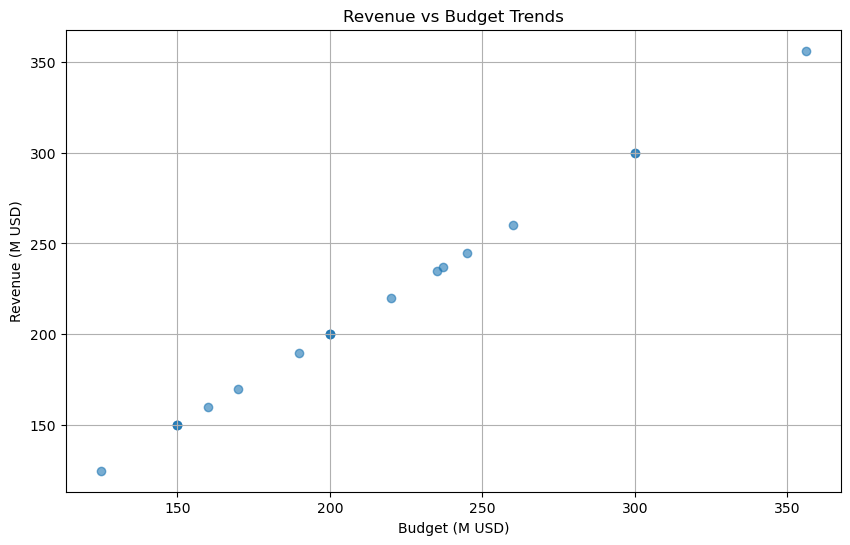

In [ ]:
#  Revenue vs Budget Visualization 
plt.figure(figsize=(10,6))
plt.scatter(df_movie['budget_musd'], df_movie['budget_musd'], alpha=0.6)
plt.xlabel('Budget (M USD)')
plt.ylabel('Revenue (M USD)')
plt.title('Revenue vs Budget Trends')
plt.grid(True)
plt.show()

In [183]:
# Average ROI by Genre Visualization
df_movie['genre_list'] = df_movie['genres'].str.split('|')

# 2. FIX: Explode the list so one movie creates multiple rows (one for each genre)
df_exploded = df_movie.explode('genre_list')

# 3. Calculate Average ROI
# Note: We group by the NEW 'genre_list' column
avg_roi = df_exploded.groupby('genre_list')['genre'].mean().sort_values(ascending=False)

# 4. Plot
plt.figure(figsize=(12,6))
plt.bar(avg_roi.index, avg_roi.values, color='skyblue', edgecolor='black')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Average ROI (Multiplier)')
plt.title('Average ROI by Genre')
plt.grid(axis='y', linestyle='--', alpha=0.5) # Optional: Adds a grid for easier reading
plt.show()

KeyError: 'Column not found: genre'

In [176]:
# -------------------------------------------------------
# Visualization 2: Bar Chart (Median ROI by Genre)
# -------------------------------------------------------
plt.figure(figsize=(12, 6))

# Prepare Data: Explode genres and calculate Median ROI
# (df_exploded created in pre-processing step)
genre_roi = df_exploded.groupby('genre_list')['roi'].median().sort_values()

# Create Horizontal Bar Chart
bars = plt.barh(genre_roi.index, genre_roi.values, color='lightgreen', edgecolor='black')

plt.title('Median ROI Distribution by Genre', fontsize=16)
plt.xlabel('Median ROI (x Times Budget)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, axis='x')

# Add Labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}x', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('bar_roi_genre.png')
plt.show()

NameError: name 'df_exploded' is not defined

<Figure size 1200x600 with 0 Axes>